In [1]:
from autoencoders import *
from pdb_utils import *

import pickle
import numpy as np
import pandas as pd
import random

import numpy as np
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected
from functools import partial
import sys

from Bio import PDB
import numpy as np
import os
import cv2

import matplotlib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression

import time

In [2]:
def nice_time(start,end):
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    print("Runtime: {:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

In [3]:
with open('pickle files/fold_groups.pkl', 'r') as f:
    fold_dict = pickle.load(f)

In [4]:
with open('pickle files/label_dict.pkl', 'rb') as f:
    label_dict = pickle.load(f)

In [181]:
def pdbClassifier(X,y,label_dict,classifier):           
    uniques = list(set(y))
    print("Number of labels: %d"%len(uniques))
    group2id = dict(zip(uniques, range(len(uniques))))
    y = np.array(list(map(lambda x: group2id[x], y)))
    
    # Stratified Cross Validation
    sss = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
    C = 1
    acc_test, prec_test, rec_test = 0,0,0
    acc_train, prec_train, rec_train = 0,0,0
    s_time = time.time()
    for train_index, test_index in sss.split(X, y):
        #print("\nStratified Cross Validation - %d"%C)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Fitting Random Forest Classification to the Training set
        classifier = classifier
        classifier.fit(X_train, y_train)
        
        # Print train/test accuracy
        y_pred_train = classifier.predict(X_train)
        #print "Train accuracy: ",accuracy_score(y_train, y_pred_train)
        y_pred_test = classifier.predict(X_test)
        #print "Test accuracy: ",accuracy_score(y_test, y_pred_test)
        
        acc_test+=accuracy_score(y_test, y_pred_test)
        prec_test+=precision_score(y_test, y_pred_test, average='weighted')
        rec_test+=recall_score(y_test, y_pred_test, average='weighted')
        
        acc_train+=accuracy_score(y_train, y_pred_train)
        prec_train+=precision_score(y_train, y_pred_train, average='weighted')
        rec_train+=recall_score(y_train, y_pred_train, average='weighted')
        
        C+=1
    end = time.time()
    nice_time(s_time,end)
    print "\nTRAIN SCORES"
    print "\naverage accuracy_score: ", acc_train/10
    print "average precision_score: ", prec_train/10
    print "average recall_score: ", rec_train/10
    print "TEST SCORES"
    print "\naverage accuracy_score: ", acc_test/10
    print "average precision_score: ", prec_test/10
    print "average recall_score: ", rec_test/10
    
    return acc_train/10., acc_test/10.

In [6]:
selected_folds = filter(lambda x: x[1]==10, map(lambda x: (x[0],len(x[1])), fold_dict.items()))
len(selected_folds)

19

In [7]:
s_time = time.time()
structures = []

for fold,_ in selected_folds:
    for pdb in fold_dict[fold]:
        pdb_path = os.path.join("PDBs", pdb+".pdb")
        parser = PDB.PDBParser()
        structure = parser.get_structure(pdb, pdb_path)
        structures.append(structure)
end = time.time()
nice_time(s_time,end)

Runtime: 00:00:25.40


## Fold Classification with Strategy 1

In [203]:
print("\nCreating distance matrices with Strategy 1")
s_time = time.time()
matrixdict_s1 = DistanceMatrixDict(structures, resize_strategy="strategy1", resize_to=(64,64),removeSymmetry=True)
end = time.time()
nice_time(s_time,end)


Creating distance matrices with Strategy 1
Runtime: 00:00:31.50


In [204]:
pdb_names, features = list(matrixdict_s1.keys()), list(matrixdict_s1.values())
input_size = len(features[0])
print("Number of samples: %d"%len(pdb_names))
print("Input size: %d"%input_size)

Number of samples: 190
Input size: 2016


In [205]:
print("Linear Autoencoder - 100 epochs")
s_time = time.time()
new_features, loss = LinearAutoencoder(features, input_size, 50, 100, learning_rate=0.0001)
end = time.time()
nice_time(s_time,end)

Linear Autoencoder - 100 epochs
Runtime: 00:00:22.66


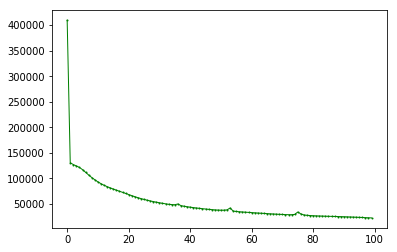

In [206]:
# LOSS GRAPH
fig, ax = plt.subplots()
ax.plot(range(0,len(loss)), loss, 'go-', linewidth=1, markersize=1)

In [207]:
X = np.array(new_features)
y_family, y_superfamily, y_fold, y_class = [], [], [], []

for pdb in pdb_names:
    y_family.append(label_dict[pdb])
    y_superfamily.append(".".join(label_dict[pdb].split(".")[:3]))
    y_fold.append(".".join(label_dict[pdb].split(".")[:2]))
    y_class.append(".".join(label_dict[pdb].split(".")[0]))
print(y_family[0], y_superfamily[0], y_fold[0], y_class[0])

('c.114.1.2', 'c.114.1', 'c.114', 'c')


In [208]:
uniques = list(set(y_fold))
group2id = dict(zip(uniques, range(len(uniques))))
y = np.array(list(map(lambda x: group2id[x], y_fold)))

# Random Forest Parameter Optimization

In [209]:
from sklearn.ensemble import RandomForestClassifier

params = {'max_depth':range(1,11), 
          'criterion':('gini', 'entropy'), 
          'warm_start':(True,False),
         'n_estimators': (10,50,100,200,500)}

rf = RandomForestClassifier(random_state=0)
clf = GridSearchCV(rf, params, cv=5)

clf.fit(X, y)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'warm_start': (True, False), 'n_estimators': (10, 50, 100, 200, 500), 'criterion': ('gini', 'entropy'), 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [210]:
clf.best_params_

{'criterion': 'entropy',
 'max_depth': 6,
 'n_estimators': 500,
 'warm_start': True}

In [211]:
clf.best_score_

0.8736842105263158

In [212]:
clf.score(X,y)

1.0

In [213]:
rfx = RandomForestClassifier(criterion= 'entropy', max_depth= 6, n_estimators= 500, warm_start= True, random_state=0)
acc_train, acc_test = pdbClassifier(np.array(X), np.array(y) , label_dict, rfx)

Number of labels: 19
Runtime: 00:00:02.61

TRAIN SCORES

average accuracy_score:  0.9736842105263157
average precision_score:  0.9765058479532165
average recall_score:  0.9736842105263157
TEST SCORES

average accuracy_score:  0.9736842105263157
average precision_score:  0.982456140350877
average recall_score:  0.9736842105263157


## Fold Classification with Strategy 2

In [67]:
print("\nCreating distance matrices with Strategy 2")
s_time = time.time()
matrixdict_s2 = DistanceMatrixDict(structures, resize_strategy="strategy2", resize_to=(64,64))
end = time.time()
nice_time(s_time,end)


Creating distance matrices with Strategy 2
Runtime: 00:00:31.33


In [68]:
pdb_names, features = list(matrixdict_s2.keys()), list(matrixdict_s2.values())
input_size = len(features[0])
print("Number of samples: %d"%len(pdb_names))
print("Input size: %d"%input_size)

Number of samples: 888
Input size: 4096


In [69]:
print("Linear Autoencoder - 100 epochs")
s_time = time.time()
new_features, loss = LinearAutoencoder(features, input_size, 50, 100, learning_rate=0.0001)
end = time.time()
nice_time(s_time,end)

Linear Autoencoder - 100 epochs
Runtime: 00:01:50.57


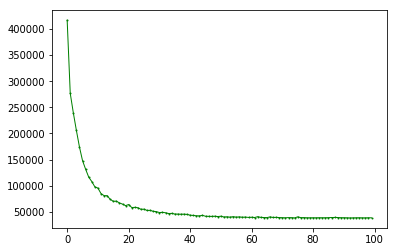

In [70]:
# LOSS GRAPH
fig, ax = plt.subplots()
ax.plot(range(0,len(loss)), loss, 'go-', linewidth=1, markersize=1)

In [71]:
X = np.array(new_features)

In [72]:
new_feature_dict = {}
for i in enumerate(pdb_names):
    if "sample" in i[1]:
        pdb = i[1].split("sample")[0]
    else:
        pdb = i[1]
    new_feature_dict.setdefault(pdb,[])
    new_feature_dict[pdb].append(X[i[0]])

In [73]:
X_train = []
y_family, y_superfamily, y_fold, y_class = [], [], [], []

for pdb,vector in new_feature_dict.items():
    X_train.append(np.average(vector,axis=0))
    p = pdb.split("sample")[0]
    y_family.append(label_dict[p])
    y_superfamily.append(".".join(label_dict[p].split(".")[:3]))
    y_fold.append(".".join(label_dict[p].split(".")[:2]))
    y_class.append(".".join(label_dict[p].split(".")[0]))

In [74]:
uniques = list(set(y_fold))
group2id = dict(zip(uniques, range(len(uniques))))
y = np.array(list(map(lambda x: group2id[x], y_fold)))

In [75]:
len(X_train)

190

# Sample size optimization

In [163]:
train_acc = []
test_acc = []

for size in [5,10,20,30,40,50,60,70,80,90,100,150,200]:
    print(size)
    matrixdict_s2 = DistanceMatrixDict(structures, resize_strategy="strategy2", resize_to=(64,64), sample_size=size)
    pdb_names, features = list(matrixdict_s2.keys()), list(matrixdict_s2.values())
    input_size = len(features[0])
    new_features, loss = LinearAutoencoder(features, input_size, 50, 100, learning_rate=0.0001)
    X = np.array(new_features)
    new_feature_dict = {}
    for i in enumerate(pdb_names):
        if "sample" in i[1]:
            pdb = i[1].split("sample")[0]
        else:
            pdb = i[1]
        new_feature_dict.setdefault(pdb,[])
        new_feature_dict[pdb].append(X[i[0]])
    X_train = []
    y_family, y_superfamily, y_fold, y_class = [], [], [], []

    for pdb,vector in new_feature_dict.items():
        X_train.append(np.average(vector,axis=0))
        p = pdb.split("sample")[0]
        y_family.append(label_dict[p])
        y_superfamily.append(".".join(label_dict[p].split(".")[:3]))
        y_fold.append(".".join(label_dict[p].split(".")[:2]))
        y_class.append(".".join(label_dict[p].split(".")[0]))
    
    rf = RandomForestClassifier(random_state=0, criterion='entropy', warm_start=True, n_estimators=50, max_depth=3)
    acc_train, acc_test = pdbClassifier(np.array(X_train), np.array(y_fold) , label_dict, rf)
    train_acc.append(acc_train)
    test_acc.append(acc_test)

5
Number of labels: 19
Runtime: 00:00:00.20
TRAIN SCORES

average accuracy_score:  0.7473684210526317
average precision_score:  0.7744872233030129
average recall_score:  0.7473684210526317
TEST SCORES

average accuracy_score:  0.6684210526315789
average precision_score:  0.6682456140350876
average recall_score:  0.6684210526315789
10
Number of labels: 19
Runtime: 00:00:00.20
TRAIN SCORES

average accuracy_score:  0.7677631578947368
average precision_score:  0.8091685653527758
average recall_score:  0.7677631578947368
TEST SCORES

average accuracy_score:  0.718421052631579
average precision_score:  0.7537719298245614
average recall_score:  0.718421052631579
20
Number of labels: 19
Runtime: 00:00:00.22
TRAIN SCORES

average accuracy_score:  0.7868421052631579
average precision_score:  0.8243859357017251
average recall_score:  0.7868421052631579
TEST SCORES

average accuracy_score:  0.7473684210526316
average precision_score:  0.7975438596491228
average recall_score:  0.7473684210526316
3

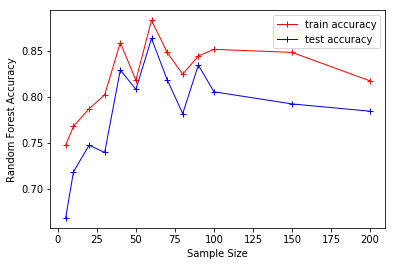

In [165]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

all_x = a[:5] + train_acc + a[6:]
all_y = b[:5] + test_acc + b[6:]

ax.plot([5,10,20,30,40,50,60,70,80,90,100,150,200],np.array(train_acc)/10, "r-+", linewidth=1, label="train accuracy")
ax.plot([5,10,20,30,40,50,60,70,80,90,100,150,200],np.array(test_acc)/10, "b-+", linewidth=1, label="test accuracy")
ax.legend()
ax.set_ylabel("Random Forest Accuracy")
ax.set_xlabel("Sample Size")
plt.show()

In [171]:
train_acc[6]

8.828947368421053

In [172]:
test_acc[6]

8.631578947368421

In [168]:
import pickle
import plotly.plotly as py
import plotly
import plotly.graph_objs as go

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)

plotly.offline.plot({
"data": [
    go.Scatter(x=[5,10,20,30,40,50,60,70,80,90,100,150,200],y=np.array(train_acc))
]
})

'file:///Users/hacertilbec/Documents/GitHub/Protein-Vectorization/Protein Distance Matrix/temp-plot.html'

# Random Forest

In [178]:
matrixdict_s2 = DistanceMatrixDict(structures, resize_strategy="strategy2", resize_to=(64,64), sample_size=60)
pdb_names, features = list(matrixdict_s2.keys()), list(matrixdict_s2.values())
input_size = len(features[0])
new_features, loss = LinearAutoencoder(features, input_size, 50, 100, learning_rate=0.0001)
X = np.array(new_features)
new_feature_dict = {}
for i in enumerate(pdb_names):
    if "sample" in i[1]:
        pdb = i[1].split("sample")[0]
    else:
        pdb = i[1]
    new_feature_dict.setdefault(pdb,[])
    new_feature_dict[pdb].append(X[i[0]])
X_train = []
y_family, y_superfamily, y_fold, y_class = [], [], [], []

for pdb,vector in new_feature_dict.items():
    X_train.append(np.average(vector,axis=0))
    p = pdb.split("sample")[0]
    y_family.append(label_dict[p])
    y_superfamily.append(".".join(label_dict[p].split(".")[:3]))
    y_fold.append(".".join(label_dict[p].split(".")[:2]))
    y_class.append(".".join(label_dict[p].split(".")[0]))

In [179]:
uniques = list(set(y_fold))
group2id = dict(zip(uniques, range(len(uniques))))
y = np.array(list(map(lambda x: group2id[x], y_fold)))

In [180]:
from sklearn.ensemble import RandomForestClassifier

params = {'max_depth':range(1,11), 
          'criterion':('gini', 'entropy'), 
          'warm_start':(True,False),
         'n_estimators': (10,50,100,200,500)}

rf = RandomForestClassifier(random_state=0)
clf = GridSearchCV(rf, params, cv=5)

clf.fit(X_train, y)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'warm_start': (True, False), 'n_estimators': (10, 50, 100, 200, 500), 'criterion': ('gini', 'entropy'), 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [182]:
clf.best_params_

{'criterion': 'gini', 'max_depth': 9, 'n_estimators': 500, 'warm_start': True}

In [183]:
clf.best_score_

0.6526315789473685

In [184]:
clf.score(X_train,y)

1.0

In [201]:
rfx = RandomForestClassifier(criterion= 'gini', max_depth= 9, n_estimators= 500, warm_start= True, random_state=0)
acc_train, acc_test = pdbClassifier(np.array(X_train), np.array(y) , label_dict, rfx)

Number of labels: 19
Runtime: 00:00:01.74

TRAIN SCORES

average accuracy_score:  0.9289473684210524
average precision_score:  0.9372262094630516
average recall_score:  0.9289473684210524
TEST SCORES

average accuracy_score:  0.9157894736842105
average precision_score:  0.9275438596491228
average recall_score:  0.9157894736842105


## Sparse Autoencoder

In [118]:
def kl_divergence(p, q):
    # Kullback Leibler divergence
    return p * tf.log(p / q) + (1 - p) * tf.log((1 - p) / (1 - q))

def SparseAutoencoder(X_train, n_input, n_hidden, n_iteration, batch_size=20, learning_rate = 0.001,sparsity_target = 0.1, sparsity_weight = 0.2):
    n_inputs = n_input # input is flatten version of input matrix
    n_hidden = n_hidden
    n_outputs = n_inputs
    
    sparsity_target = sparsity_target
    sparsity_weight = sparsity_weight

    learning_rate = learning_rate

    X = tf.placeholder(tf.float32, shape=[None, n_inputs])
    hidden = fully_connected(X, n_hidden) # not shown
    outputs = fully_connected(hidden, n_outputs)                     # not shown

    hidden_mean = tf.reduce_mean(hidden, axis=0) # batch mean
    kl = kl_divergence(sparsity_target, hidden_mean)
    sparsity_loss = tf.reduce_sum(kl)
    reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE
    loss = reconstruction_loss + sparsity_weight * sparsity_loss

    optimizer = tf.train.AdamOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

    init = tf.global_variables_initializer()

    n_iterations = n_iteration # Number of iterations
    codings = hidden # the output of the hidden layer provides the codings

    with tf.Session() as sess:
        init.run()
        loss = []
        for iteration in range(n_iterations):
            sys.stdout.flush()
            iteration_loss = []
            
            start = 0
            end = batch_size
            print iteration
            while start < len(X_train):
                X_batch = X_train[start:end]
                _, loss_val = sess.run([training_op, hidden], feed_dict={X: X_batch}) # no labels (unsupervised)
                start+=batch_size
                end+=batch_size
                iteration_loss.append(loss_val)
                print loss_val
            loss.append(sum(iteration_loss)/float(len(X_train)))

        # Test on the same protein
        codings_val = codings.eval(feed_dict={X: X_train})

    return codings_val, loss

In [119]:
print("Sparse Autoencoder - 100 epochs")
s_time = time.time()
new_features, loss = SparseAutoencoder(features, input_size, 50, 10, batch_size =20, learning_rate=0.001,sparsity_target=0.3,sparsity_weight=0.2)
end = time.time()
nice_time(s_time,end)

# LOSS GRAPH
fig, ax = plt.subplots()
ax.plot(range(0,len(loss)), loss, 'go-', linewidth=1, markersize=1)

Sparse Autoencoder - 100 epochs
0
[[4.87974167e+00 0.00000000e+00 1.69265366e+01 1.62925243e+00
  7.63184738e+00 0.00000000e+00 0.00000000e+00 3.72521162e+00
  2.64244289e+01 4.63035431e+01 1.35782404e+01 0.00000000e+00
  0.00000000e+00 3.30588036e+01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 1.67468681e+01
  3.92055016e+01 0.00000000e+00 8.08483791e+00 1.26738300e+01
  1.97836056e+01 0.00000000e+00 3.99948349e+01 0.00000000e+00
  3.45615578e+01 0.00000000e+00 0.00000000e+00 2.03316307e+01
  0.00000000e+00 2.63177013e+00 7.61694908e-01 1.34636841e+01
  0.00000000e+00 4.81317663e+00 1.96373444e+01 0.00000000e+00
  2.03511810e+01 0.00000000e+00 1.34109802e+01 4.74850960e+01
  2.33902073e+01 0.00000000e+00 0.00000000e+00 2.66866112e+00
  0.00000000e+00 0.00000000e+00]
 [8.87278366e+00 1.25762920e+01 1.65528774e+01 7.16990566e+00
  9.82933712e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  9.84496403e+00 5.42515259e+01 3.44213343e+00 4.94433117e+00
  9

[[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan na

[[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan na

[[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan na

[[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan na

ValueError: operands could not be broadcast together with shapes (20,50) (8,50) 

In [82]:
X = np.array(new_features)

In [83]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0, penalty="l2", multi_class='multinomial', solver='lbfgs')
pdbClassifier(X, y_fold, label_dict, clf)

Number of labels: 19

Stratified Cross Validation - 1
Training...

Stratified Cross Validation - 2
Training...

Stratified Cross Validation - 3
Training...

Stratified Cross Validation - 4
Training...

Stratified Cross Validation - 5
Training...

Stratified Cross Validation - 6
Training...

Stratified Cross Validation - 7
Training...

Stratified Cross Validation - 8
Training...

Stratified Cross Validation - 9
Training...

Stratified Cross Validation - 10
Training...
Runtime: 00:00:00.52
TRAIN SCORES

average accuracy_score:  0.3019736842105263
average precision_score:  0.21593046122370688
average recall_score:  0.3019736842105263
TEST SCORES

average accuracy_score:  0.32631578947368417
average precision_score:  0.2142948279790385
average recall_score:  0.32631578947368417
